# Segmentation des clients par régression logistique

In [7]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import pickle

In [8]:
import scipy
scipy.__version__ # il faut cette version pr eviter les pb

'1.12.0'

In [9]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [10]:
# Importation des données
BUCKET = "projet-bdc2324-team1/Generalization/musee"

FILE_PATH_S3 = BUCKET + "/" + "Train_set.csv"

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    dataset_train = pd.read_csv(file_in, sep=",")

FILE_PATH_S3 = BUCKET + "/" + "Test_set.csv"

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    dataset_test = pd.read_csv(file_in, sep=",")

# Choosed features
features = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min',
           'purchase_date_max', 'time_between_purchase', 'nb_tickets_internet', 'fidelity', 'is_partner', 'is_email_true', 
            'opt_in', 'gender_female', 'gender_male', 'country_fr', 'nb_campaigns', 'nb_campaigns_opened', 'y_has_purchased'] 


/tmp/ipykernel_3769/2190163697.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")
/tmp/ipykernel_3769/2190163697.py:12: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_test = pd.read_csv(file_in, sep=",")


In [14]:
dataset_train.columns

Index(['customer_id', 'nb_tickets', 'nb_purchases', 'total_amount',
       'nb_suppliers', 'vente_internet_max', 'purchase_date_min',
       'purchase_date_max', 'time_between_purchase', 'nb_tickets_internet',
       'street_id', 'structure_id', 'mcp_contact_id', 'fidelity', 'tenant_id',
       'is_partner', 'deleted_at', 'gender', 'is_email_true', 'opt_in',
       'last_buying_date', 'max_price', 'ticket_sum', 'average_price',
       'average_purchase_delay', 'average_price_basket',
       'average_ticket_basket', 'total_price', 'purchase_count',
       'first_buying_date', 'country', 'gender_label', 'gender_female',
       'gender_male', 'gender_other', 'country_fr', 'nb_campaigns',
       'nb_campaigns_opened', 'time_to_open', 'y_has_purchased'],
      dtype='object')

In [12]:
dataset_test.isna().sum() / len(dataset_test)

customer_id               0.000000
nb_tickets                0.000000
nb_purchases              0.000000
total_amount              0.000000
nb_suppliers              0.000000
vente_internet_max        0.000000
purchase_date_min         0.000000
purchase_date_max         0.000000
time_between_purchase     0.000000
nb_tickets_internet       0.000000
street_id                 0.000000
structure_id              0.908249
mcp_contact_id            0.548870
fidelity                  0.000000
tenant_id                 0.000000
is_partner                0.000000
deleted_at                1.000000
gender                    0.000000
is_email_true             0.000000
opt_in                    0.000000
last_buying_date          0.377696
max_price                 0.377696
ticket_sum                0.000000
average_price             0.212994
average_purchase_delay    0.377696
average_price_basket      0.377696
average_ticket_basket     0.377696
total_price               0.164701
purchase_count      

In [7]:
dataset_train[['event_type_id', 'name_event_types']].drop_duplicates()

event_type_id          name_event_types
0            2.0  offre muséale individuel
1            4.0          spectacle vivant
2            5.0      offre muséale groupe
3            NaN                       NaN

In [8]:
#Choose type of event 
type_event_choosed = 5

dataset_test = dataset_test[(dataset_test['event_type_id'] == type_event_choosed) | np.isnan(dataset_test['event_type_id'])]
dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
dataset_train = dataset_train[(dataset_train['event_type_id'] == type_event_choosed) | np.isnan(dataset_train['event_type_id'])]
dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

In [9]:
dataset_train.isna().sum()/len(dataset_train)

customer_id               0.000000
event_type_id             0.967882
nb_tickets                0.000000
nb_purchases              0.000000
total_amount              0.000000
nb_suppliers              0.000000
vente_internet_max        0.000000
purchase_date_min         0.967882
purchase_date_max         0.967882
time_between_purchase     0.967882
nb_tickets_internet       0.000000
name_event_types          0.967882
avg_amount                0.967882
street_id                 0.000000
is_partner                0.000000
gender                    0.000000
is_email_true             0.000000
opt_in                    0.000000
structure_id              0.856471
mcp_contact_id            0.297844
last_buying_date          0.642312
max_price                 0.642312
ticket_sum                0.000000
average_price             0.107403
fidelity                  0.000000
average_purchase_delay    0.642312
average_price_basket      0.642312
average_ticket_basket     0.642312
total_price         

In [10]:
dataset_train[['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'nb_tickets_internet', 'opt_in', 'fidelity', 'nb_campaigns', 'nb_campaigns_opened']].isna().sum()
# pas de NaN, OK !

nb_tickets             0
nb_purchases           0
total_amount           0
nb_suppliers           0
vente_internet_max     0
nb_tickets_internet    0
opt_in                 0
fidelity               0
nb_campaigns           0
nb_campaigns_opened    0
dtype: int64

In [11]:
dataset_train['y_has_purchased'].sum()

228.0

In [12]:

reg_columns = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'nb_tickets_internet', 'opt_in', 'fidelity', 'nb_campaigns', 'nb_campaigns_opened']

X_train = dataset_train[reg_columns]
y_train = dataset_train['y_has_purchased']
X_test = dataset_test[reg_columns]
y_test = dataset_test['y_has_purchased']

# Fit and transform the scaler on the training data
scaler = StandardScaler()

# Transform the test data using the same scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Create and fit the linear regression model
logit_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
logit_model.fit(X_train_scaled, y_train)

y_pred = logit_model.predict(X_test_scaled)

#Evaluation du modèle 
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9986037223669636
Confusion Matrix:
 [[128000     37]
 [   142     19]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    128037
         1.0       0.34      0.12      0.18       161

    accuracy                           1.00    128198
   macro avg       0.67      0.56      0.59    128198
weighted avg       1.00      1.00      1.00    128198



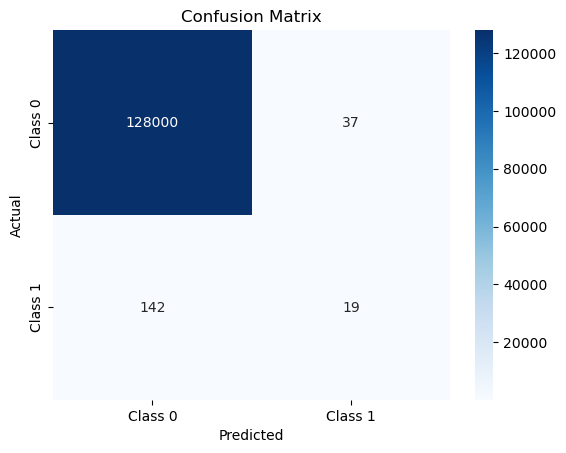

In [13]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Ajout TP : test d'une nouvelle pipeline

In [14]:
# etape supp : suppression du client 1 (outlier car client anonyme)

dataset_train = dataset_train[dataset_train["customer_id"]!=1]

In [15]:
# definition des variables utilisées

numeric_features = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'nb_tickets_internet', 'fidelity', 'nb_campaigns', 'nb_campaigns_opened']
# categorical_features = ["opt_in"]
encoded_features = ["opt_in", "vente_internet_max"]
features = numeric_features + encoded_features
X_train = dataset_train[features]
y_train = dataset_train['y_has_purchased']
X_test = dataset_test[features]
y_test = dataset_test['y_has_purchased']

In [16]:
### variable fidelity

X_train["fidelity"].describe() # sûrement un problème d'outlier pour fidelity
# X_train["total_amount"].describe()

count    122016.000000
mean          0.307656
std           3.135563
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         907.000000
Name: fidelity, dtype: float64

In [17]:
X_train[X_train["fidelity"]>5]

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
3              0.0           0.0           0.0           0.0   
15          2233.0          66.0       25703.0           2.0   
24             0.0           0.0           0.0           0.0   
28           557.0          25.0           0.0           2.0   
34             0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...   
144823         0.0           0.0           0.0           0.0   
144824         0.0           0.0           0.0           0.0   
144868         0.0           0.0           0.0           0.0   
144877         0.0           0.0           0.0           0.0   
150595         0.0           0.0           0.0           0.0   

        nb_tickets_internet  fidelity  nb_campaigns  nb_campaigns_opened  \
3                       0.0       173           2.0                  0.0   
15                      2.0        94         130.0                 60.0   
24                      0.0       224          16.0                  0.0   
28                    175.0        34          32.0                 15.0   
34                      0.0        24           0.0                  0.0   
...                     ...       ...           ...                  ...   
144823                  0.0         9           0.0                  0.0   
144824                  0.0       120           0.0                  0.0   
144868                  0.0       907           0.0                  0.0   
144877                  0.0         8           0.0                  0.0   
150595                  0.0         6           0.0                  0.0   

        opt_in  vente_internet_max  
3         True                 0.0  
15        True                 1.0  
24        True                 0.0  
28        True                 1.0  
34        True                 0.0  
...        ...                 ...  
144823    True                 0.0  
144824    True                 0.0  
144868    True                 0.0  
144877    True                 0.0  
150595    True                 0.0  

[279 rows x 10 columns]

In [18]:
# on transforme opt_in en indicatrice

dataset_train["opt_in"] = dataset_train["opt_in"].astype(int)
dataset_train

customer_id  event_type_id  nb_tickets  nb_purchases  total_amount  \
3                 2            NaN         0.0           0.0           0.0   
4                 3            NaN         0.0           0.0           0.0   
6                 5            NaN         0.0           0.0           0.0   
7                 6            NaN         0.0           0.0           0.0   
8                 7            NaN         0.0           0.0           0.0   
...             ...            ...         ...           ...           ...   
152554      1256102            NaN         0.0           0.0           0.0   
152555      1256103            NaN         0.0           0.0           0.0   
152556      1256104            NaN         0.0           0.0           0.0   
152557      1256105            NaN         0.0           0.0           0.0   
152558      1256106            NaN         0.0           0.0           0.0   

        nb_suppliers  vente_internet_max  purchase_date_min  \
3                0.0                 0.0                NaN   
4                0.0                 0.0                NaN   
6                0.0                 0.0                NaN   
7                0.0                 0.0                NaN   
8                0.0                 0.0                NaN   
...              ...                 ...                ...   
152554           0.0                 0.0                NaN   
152555           0.0                 0.0                NaN   
152556           0.0                 0.0                NaN   
152557           0.0                 0.0                NaN   
152558           0.0                 0.0                NaN   

        purchase_date_max  time_between_purchase  ...  tenant_id gender_label  \
3                     NaN                    NaN  ...       1311         male   
4                     NaN                    NaN  ...       1311         male   
6                     NaN                    NaN  ...       1311         male   
7                     NaN                    NaN  ...       1311         male   
8                     NaN                    NaN  ...       1311       female   
...                   ...                    ...  ...        ...          ...   
152554                NaN                    NaN  ...       1311       female   
152555                NaN                    NaN  ...       1311        other   
152556                NaN                    NaN  ...       1311        other   
152557                NaN                    NaN  ...       1311        other   
152558                NaN                    NaN  ...       1311        other   

        gender_female  gender_male  gender_other  country_fr  nb_campaigns  \
3                   0            1             0         1.0           2.0   
4                   0            1             0         1.0         125.0   
6                   0            1             0         1.0           2.0   
7                   0            1             0         1.0          17.0   
8                   1            0             0         1.0          27.0   
...               ...          ...           ...         ...           ...   
152554              1            0             0         1.0           0.0   
152555              0            0             1         NaN           0.0   
152556              0            0             1         NaN           0.0   
152557              0            0             1         NaN           0.0   
152558              0            0             1         NaN           0.0   

        nb_campaigns_opened               time_to_open  y_has_purchased  
3                       0.0                        NaN              0.0  
4                      71.0  1 days 04:13:20.492957746              0.0  
6                       0.0                        NaN              0.0  
7                       0.0                        NaN              0.0  
8                      13.0  5 day

In [16]:
# definition des variables utilisées

numeric_features = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'nb_tickets_internet', 'fidelity', 'nb_campaigns', 'nb_campaigns_opened']
# categorical_features = ["opt_in"]
encoded_features = ["opt_in", "vente_internet_max"]
features = numeric_features + encoded_features
X_train = dataset_train[features]
y_train = dataset_train['y_has_purchased']
X_test = dataset_test[features]
y_test = dataset_test['y_has_purchased']

### Autre ajout : travail de preprocessing des données - étude des outliers

In [60]:
# 1. number of purchases

X_train["nb_purchases"].describe()

count    128198.000000
mean          0.582536
std         181.774597
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       65082.000000
Name: nb_purchases, dtype: float64

In [84]:
X_train[X_train["nb_purchases"]>1]

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
2         122983.0       65082.0      878762.5           5.0   
15          2773.0          81.0       32338.0           2.0   
28           282.0          15.0           0.0           2.0   
29            40.0           2.0           0.0           1.0   
31            52.0           2.0           0.0           1.0   
...            ...           ...           ...           ...   
147155         4.0           2.0          44.0           1.0   
147242         3.0           2.0          40.0           1.0   
147414        12.0           2.0         132.0           1.0   
147636        15.0           2.0         165.0           1.0   
147950         2.0           2.0          29.0           1.0   

        nb_tickets_internet  fidelity  nb_campaigns  nb_campaigns_opened  \
2                       9.0    330831           0.0                  0.0   
15                      2.0        94         126.0                 50.0   
28                     53.0        34          32.0                 13.0   
29                      0.0         4          24.0                 17.0   
31                      0.0         5          22.0                  6.0   
...                     ...       ...           ...                  ...   
147155                  4.0         2           0.0                  0.0   
147242                  3.0         2           0.0                  0.0   
147414                 12.0         2           0.0                  0.0   
147636                 15.0         2           0.0                  0.0   
147950                  2.0         2           0.0                  0.0   

        opt_in  vente_internet_max  
2            0                 1.0  
15           1                 1.0  
28           1                 1.0  
29           1                 0.0  
31           1                 0.0  
...        ...                 ...  
147155       0                 1.0  
147242       0                 1.0  
147414       0                 1.0  
147636       0                 1.0  
147950       0                 1.0  

[747 rows x 10 columns]

In [65]:
np.quantile(X_train["nb_purchases"], 0.99)

1.0

In [70]:
### 2. nb tickets

print(X_train["nb_tickets"].describe())
np.quantile(X_train["nb_tickets"], 0.99)

count    128198.000000
mean          1.946941
std         343.940117
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      122983.000000
Name: nb_tickets, dtype: float64


23.0

In [73]:
# 3. total amount

print(X_train["total_amount"].describe())
np.quantile(X_train["total_amount"], 0.99)

count    128198.000000
mean         10.496193
std        2457.094272
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      878762.500000
Name: total_amount, dtype: float64


44.0

In [76]:
# 4. fidelity

print(X_train["fidelity"].describe())
np.quantile(X_train["fidelity"], 0.99)

count    128198.000000
mean          2.924687
std         923.990506
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max      330831.000000
Name: fidelity, dtype: float64


2.0

In [79]:
# 5. nb campaigns - semble pas aberrant meme si forte variance

print(X_train["nb_campaigns"].describe())
np.quantile(X_train["nb_campaigns"], 0.99)

count    128198.000000
mean         24.276463
std          37.899868
min           0.000000
25%           1.000000
50%           4.000000
75%          28.000000
max         299.000000
Name: nb_campaigns, dtype: float64


133.0

In [80]:
### on retire les outliers - variables : nb purchases, nb tickets, total amount, fidelity

p99_nb_purchases = np.quantile(X_train["nb_purchases"], 0.99)
p99_nb_tickets = np.quantile(X_train["nb_tickets"], 0.99)
p99_total_amount = np.quantile(X_train["total_amount"], 0.99)
p99_fidelity = np.quantile(X_train["fidelity"], 0.99)



In [98]:
# filtre - on enlève les valeurs aberrantes sur les variables problématiques (retire 2% des valeurs en tt)

X_train = X_train.loc[(X_train["nb_purchases"] <= p99_nb_purchases) &
(X_train["nb_tickets"] <= p99_nb_tickets) &
(X_train["total_amount"] <= p99_total_amount) &
(X_train["fidelity"] <= p99_fidelity)]

In [99]:
X_train.head()

nb_tickets  nb_purchases  total_amount  nb_suppliers  nb_tickets_internet  \
6          0.0           0.0           0.0           0.0                  0.0   
7          0.0           0.0           0.0           0.0                  0.0   
8          0.0           0.0           0.0           0.0                  0.0   
9          0.0           0.0           0.0           0.0                  0.0   
10         0.0           0.0           0.0           0.0                  0.0   

    fidelity  nb_campaigns  nb_campaigns_opened  opt_in  vente_internet_max  
6          1           2.0                  0.0       1                 0.0  
7          1          12.0                  0.0       1                 0.0  
8          1          24.0                 10.0       1                 0.0  
9          1          14.0                  7.0       1                 0.0  
10         1          23.0                 11.0       1                 0.0

In [101]:


dataset_train = dataset_train.loc[(dataset_train["nb_purchases"] <= p99_nb_purchases) &
(dataset_train["nb_tickets"] <= p99_nb_tickets) &
(dataset_train["total_amount"] <= p99_total_amount) &
(dataset_train["fidelity"] <= p99_fidelity)]

dataset_train

customer_id  event_type_id  nb_tickets  nb_purchases  total_amount  \
6                 5            NaN         0.0           0.0           0.0   
7                 6            NaN         0.0           0.0           0.0   
8                 7            NaN         0.0           0.0           0.0   
9                 8            NaN         0.0           0.0           0.0   
10                9            NaN         0.0           0.0           0.0   
...             ...            ...         ...           ...           ...   
152645      1256102            NaN         0.0           0.0           0.0   
152646      1256103            NaN         0.0           0.0           0.0   
152647      1256104            NaN         0.0           0.0           0.0   
152648      1256105            NaN         0.0           0.0           0.0   
152649      1256106            NaN         0.0           0.0           0.0   

        nb_suppliers  vente_internet_max  purchase_date_min  \
6                0.0                 0.0                NaN   
7                0.0                 0.0                NaN   
8                0.0                 0.0                NaN   
9                0.0                 0.0                NaN   
10               0.0                 0.0                NaN   
...              ...                 ...                ...   
152645           0.0                 0.0                NaN   
152646           0.0                 0.0                NaN   
152647           0.0                 0.0                NaN   
152648           0.0                 0.0                NaN   
152649           0.0                 0.0                NaN   

        purchase_date_max  time_between_purchase  ...  tenant_id gender_label  \
6                     NaN                    NaN  ...       1311         male   
7                     NaN                    NaN  ...       1311         male   
8                     NaN                    NaN  ...       1311       female   
9                     NaN                    NaN  ...       1311       female   
10                    NaN                    NaN  ...       1311       female   
...                   ...                    ...  ...        ...          ...   
152645                NaN                    NaN  ...       1311       female   
152646                NaN                    NaN  ...       1311        other   
152647                NaN                    NaN  ...       1311        other   
152648                NaN                    NaN  ...       1311        other   
152649                NaN                    NaN  ...       1311        other   

        gender_female  gender_male  gender_other  country_fr  nb_campaigns  \
6                   0            1             0         1.0           2.0   
7                   0            1             0         1.0          12.0   
8                   1            0             0         1.0          24.0   
9                   1            0             0         1.0          14.0   
10                  1            0             0         1.0          23.0   
...               ...          ...           ...         ...           ...   
152645              1            0             0         1.0           0.0   
152646              0            0             1         NaN           0.0   
152647              0            0             1         NaN           0.0   
152648              0            0             1         NaN           0.0   
152649              0            0             1         NaN           0.0   

        nb_campaigns_opened               time_to_open  y_has_purchased  
6                       0.0                        NaN              0.0  
7                       0.0                        NaN              0.0  
8                      10.0            5 days 11:58:52              0.0  
9                       7.0  0 days 13:29:25.714285714              0.0  
10                     11.0  0 day

En enlevant les outliers, on supprime la plupart des clients ayant acheté à nouveau ... Il faut trouver un autre moyen de preprocessing qui ne dégrade pas le dataset

In [102]:
dataset_train["y_has_purchased"].sum() # pb : on passe de 161 à 19 clients ayant acheté ...

19.0

### Construction de la pipeline pour le modèle de régression logistique et résultats

In [17]:
# importations pr créer la pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score

In [18]:
# debut de la pipeline
numeric_transformer = Pipeline(steps=[
                                # ("imputer", SimpleImputer(strategy="mean")), # NaN remplacés par la moyenne, mais peu importe car on a supprimé les valeurs manquantes
                                ("scaler", StandardScaler())])
"""
categorical_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
                                    ("onehot", OneHotEncoder(handle_unknown='ignore'))]) # to deal with missing categorical data

"""
preproc = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features)])



In [20]:
# on doit prendre une métrique adaptée aux datasets déséquilibrés
balanced_scorer = make_scorer(balanced_accuracy_score)
f1_scorer = make_scorer(f1_score)

parameter_space = np.logspace(-10, 6, 17, base=2)

pipe = Pipeline([('preprocessor', preproc), ('logreg', LogisticRegression(max_iter=500))]) # prendre 5k iter
# on met plus de poids sur les observations rares (utile pr gérer le déséquilibre du dataset)
parameters4 = {'logreg__C': parameter_space, 'logreg__class_weight': ['balanced']} 
clf4 = GridSearchCV(pipe, parameters4, cv=3, scoring = f1_scorer)
clf4.fit(X_train, y_train)

# print results
# print(clf4.cv_results_)
print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best classification accuracy in train is: {}'.format(clf4.best_score_))
print('Classification accuracy on test is: {}'.format(clf4.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.0009765625, 'logreg__class_weight': 'balanced'}
Best classification accuracy in train is: 0.25403118665289387
Classification accuracy on test is: 0.0495079950799508


In [21]:
# visualisation des résultats 

y_pred = clf4.predict(X_test)

#Evaluation du modèle 
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.9517777188411676
Confusion Matrix:
 [[121855   6182]
 [     0    161]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.95      0.98    128037
         1.0       0.03      1.00      0.05       161

    accuracy                           0.95    128198
   macro avg       0.51      0.98      0.51    128198
weighted avg       1.00      0.95      0.97    128198



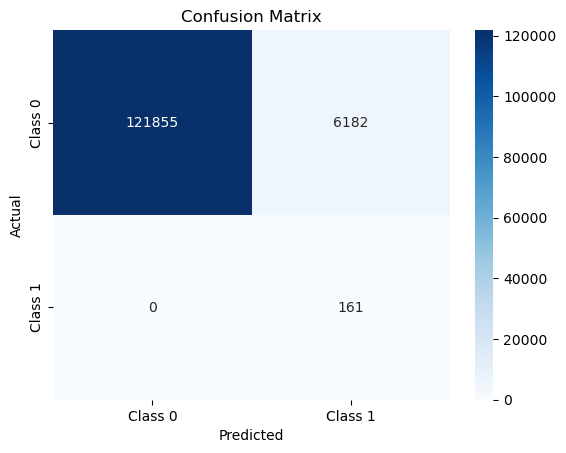

In [22]:
# matrice de confusion

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

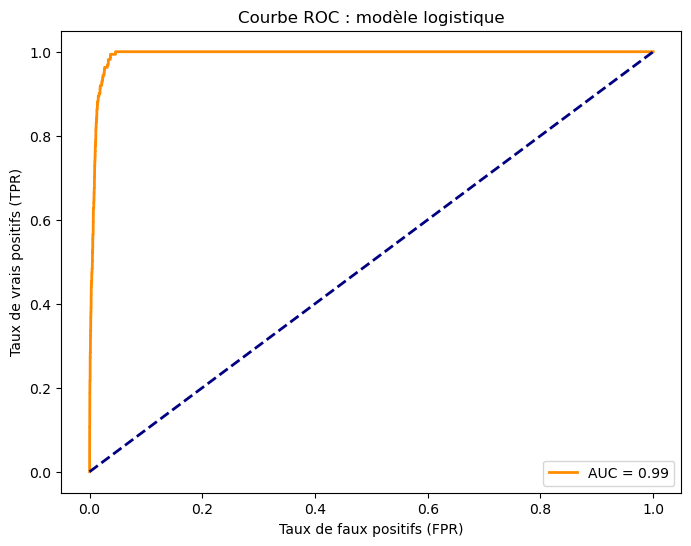

In [30]:
# on trace la courbe ROC

# Prédictions sur l'ensemble de test
y_pred_prob = clf4.predict_proba(X_test)[:, 1]

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC : modèle logistique')
plt.legend(loc='lower right')
plt.show()

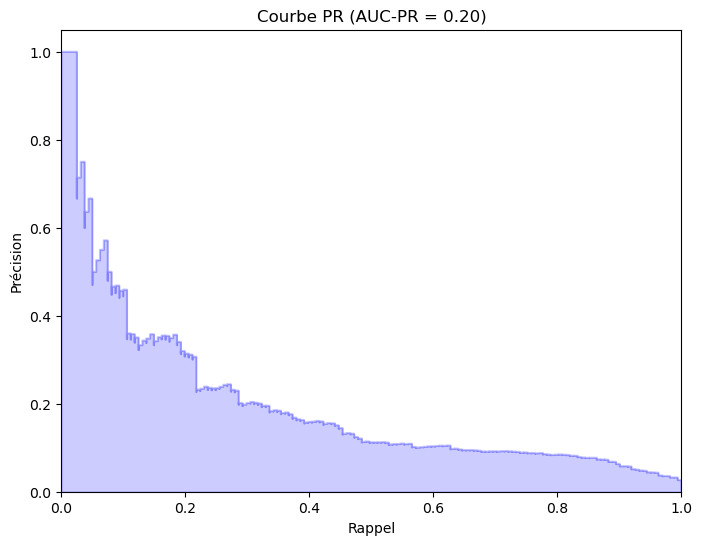

In [24]:
# Calcul des valeurs de précision et de rappel à différents seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Calcul de l'aire sous la courbe PR (AUC-PR)
average_precision = average_precision_score(y_test, y_pred_prob)

# Tracé de la courbe PR
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Courbe PR (AUC-PR = {average_precision:.2f})')
plt.show()

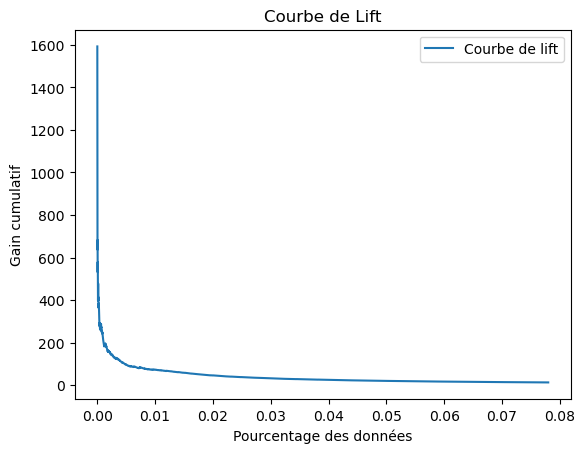

In [25]:
# utilisation d'une métrique plus adaptée aux modèles de marketing : courbe de lift

# Tri des prédictions de probabilités et des vraies valeurs
sorted_indices = np.argsort(y_pred_prob)[::-1]
y_pred_prob_sorted = y_pred_prob[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]

# Calcul du gain cumulatif
cumulative_gain = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)

# Tracé de la courbe de lift
plt.plot(np.linspace(0, 1, len(cumulative_gain))[:10000], (cumulative_gain/np.linspace(0, 1, len(cumulative_gain)))[:10000], label='Courbe de lift')
plt.xlabel('Pourcentage des données')
plt.ylabel('Gain cumulatif')
plt.title('Courbe de Lift')
plt.legend()
plt.show()

## Random forest

In [31]:
# Define models and parameters for GridSearch
params = {
            'n_estimators': [100, 150, 200],
            'max_depth': [5, 20, 30],
            'random_state' : [20]
        }


# define model and pipeline - no preprocessing
clf = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring=f1_scorer, verbose=True)
clf.fit(X_train, y_train)

print(f"Best parameters: {clf.best_params_}")
print('Best classification accuracy in train is: {}'.format(clf.best_score_))
print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))
print("------")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'max_depth': 20, 'n_estimators': 100, 'random_state': 20}
Best classification accuracy in train is: 0.3224906065485776
Classification accuracy on test is: 0.31906614785992216
------


In [32]:
# visualisation des résultats 

y_pred = clf.predict(X_test)

#Evaluation du modèle 
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.99863492410178
Confusion Matrix:
 [[127982     55]
 [   120     41]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    128037
         1.0       0.43      0.25      0.32       161

    accuracy                           1.00    128198
   macro avg       0.71      0.63      0.66    128198
weighted avg       1.00      1.00      1.00    128198



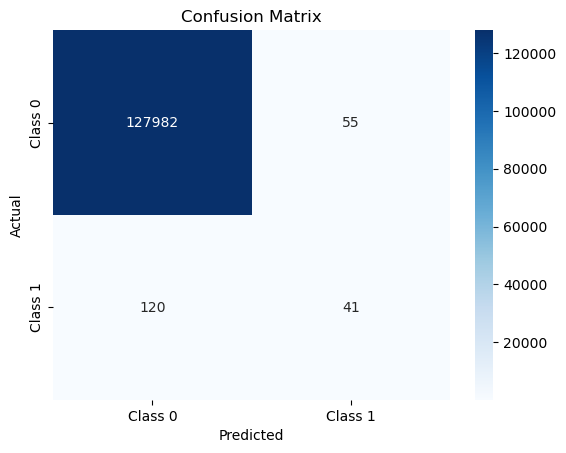

In [33]:
# matrice de confusion

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

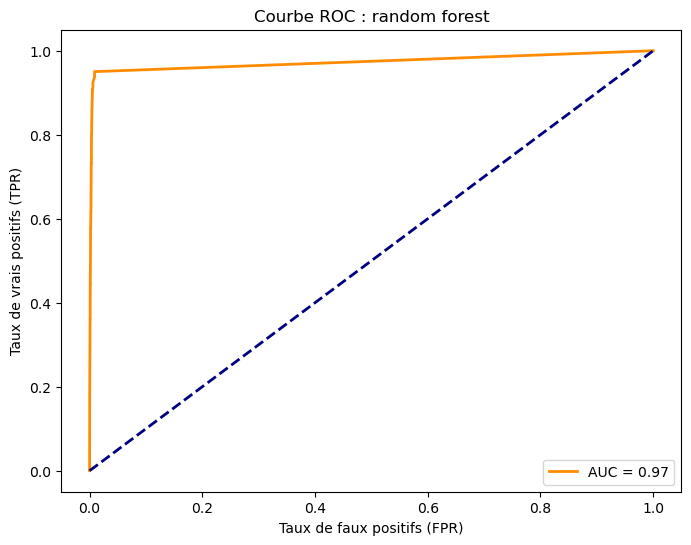

In [34]:
# on trace la courbe ROC

# Prédictions sur l'ensemble de test
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC : random forest')
plt.legend(loc='lower right')
plt.show()

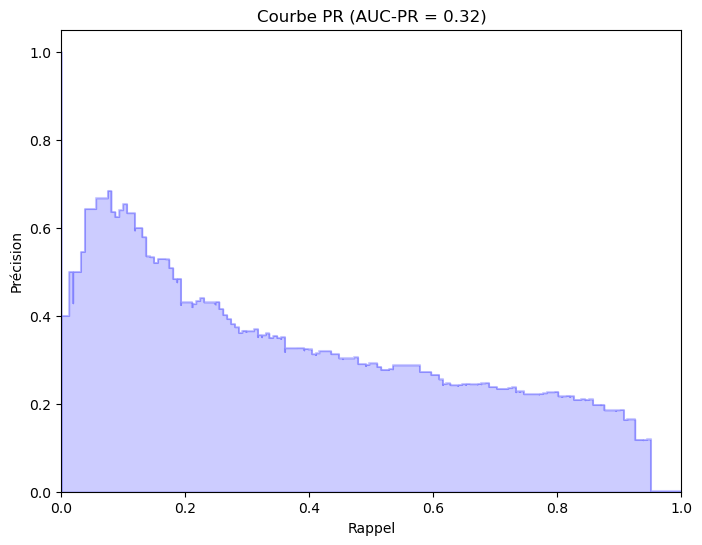

In [35]:
# Calcul des valeurs de précision et de rappel à différents seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Calcul de l'aire sous la courbe PR (AUC-PR)
average_precision = average_precision_score(y_test, y_pred_prob)

# Tracé de la courbe PR
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Courbe PR (AUC-PR = {average_precision:.2f})')
plt.show()

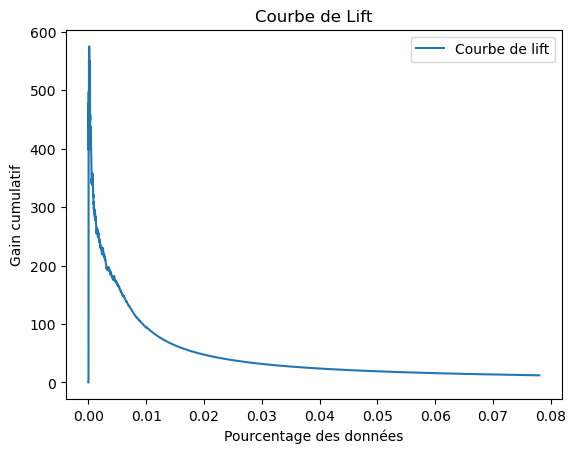

In [36]:
# utilisation d'une métrique plus adaptée aux modèles de marketing : courbe de lift

# Tri des prédictions de probabilités et des vraies valeurs
sorted_indices = np.argsort(y_pred_prob)[::-1]
y_pred_prob_sorted = y_pred_prob[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]

# Calcul du gain cumulatif
cumulative_gain = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)

# Tracé de la courbe de lift
plt.plot(np.linspace(0, 1, len(cumulative_gain))[:10000], (cumulative_gain/np.linspace(0, 1, len(cumulative_gain)))[:10000], label='Courbe de lift')
plt.xlabel('Pourcentage des données')
plt.ylabel('Gain cumulatif')
plt.title('Courbe de Lift')
plt.legend()
plt.show()

In [37]:
cumulative_gain

52512    0.000000
87081    0.000000
2695     0.000000
51486    0.006211
15       0.012422
           ...   
86959    1.000000
86960    1.000000
86961    1.000000
86962    1.000000
65836    1.000000
Name: y_has_purchased, Length: 128198, dtype: float64

## Sauvegarde des résultats (à reprendre))

In [40]:
# sauvegarde

with open('test_logit.pkl', 'wb') as file:
    pickle.dump(clf4, file)

In [41]:
# pour charger les paramètres 

# Chargement du modèle à partir du fichier
with open('test_logit.pkl', 'rb') as file:
    loaded_logit = pickle.load(file)